# Data exploration

In [153]:
%matplotlib inline
from datetime import datetime
from pymongo import MongoClient
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1000)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import langid
from whatthelang import WhatTheLang
import re

Connect to MongoDB filled with paper data from Microsoft Academic Graph

In [2]:
mongo_client = MongoClient("localhost", 27017, username="dev", password="Password4DEV")
db = mongo_client["expert_recommender"]
paper_collection = db["paper_collection"]

In [3]:
print("Total paper count:", paper_collection.estimated_document_count())
print("Total author count:", len(paper_collection.distinct("kit_authors.id")))
print("Paper properties:", ", ".join(next(paper_collection.find({})).keys()))

Total paper count: 62617
Total author count: 32303
Paper properties: _id, id, normalized_title, display_title, publication_date, citation_count, total_author_count, kit_authors, keywords, journal, conference, abstract


In [4]:
papers = pd.DataFrame(list(paper_collection.find({},{"publication_date":1, "id":1, "display_title":1})))
papers.head()

,_id,id,display_title,publication_date
0,5da869bf7e08fb472b18e1ea,2150066425,Are we ready for autonomous driving? The KITTI vision benchmark suite,2012-06-01
1,5da869bf7e08fb472b18e1eb,2133151341,The HITRAN 2008 Molecular Spectroscopic Database,2005-12-01
2,5da869bf7e08fb472b18e1ec,2115579991,Vision meets robotics: The KITTI dataset,2013-09-01
3,5da869bf7e08fb472b18e1ed,1979112419,Review of particle properties,1994-08-01
4,5da869bf7e08fb472b18e1ee,1988091937,"Balanced basis sets of split valence, triple zeta valence and quadruple zeta valence quality for H to Rn: Design and assessment of accuracy",2005-01-01


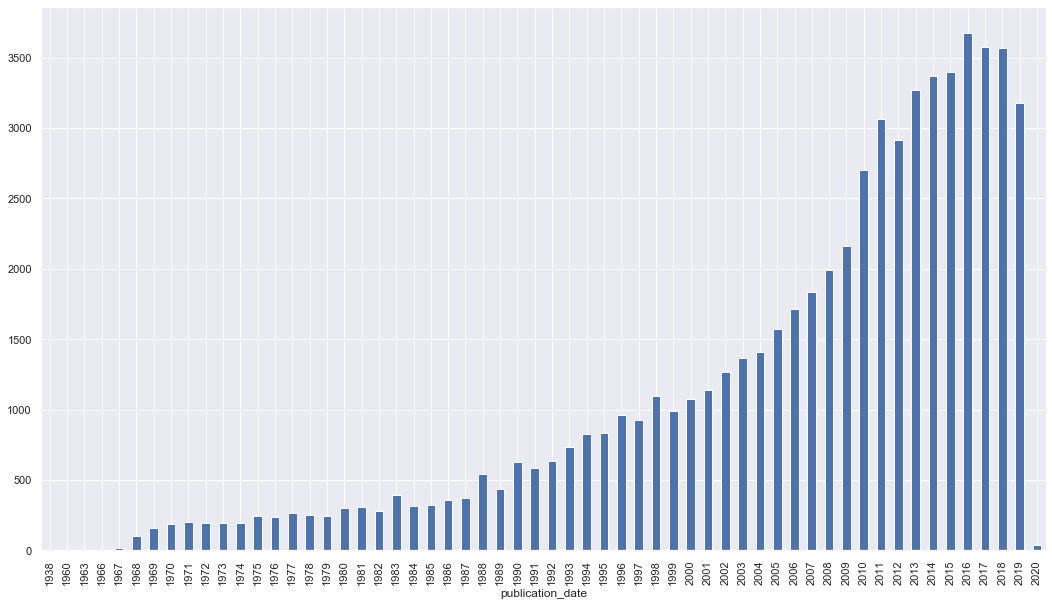

In [5]:
papers["publication_date"].groupby(papers["publication_date"].dt.year).count().plot(kind="bar", figsize=(18,10));

In [6]:
def get_authors_since(year):
    return list(paper_collection.aggregate([
        {
            "$unwind":"$kit_authors"
        },
        {
            "$group": {
                "_id": "$kit_authors.id",
                "last_paper_date": {
                    "$max": "$publication_date"
                },
                "paper_count": {
                    "$sum":1
                }
            }
        },
        {
            "$match": {
                "$and":[
                    {"paper_count": {"$gt": 1}},
                    {"last_paper_date":{"$gt":datetime(year,1,1)}}
                ]
            }
        },
        {
            "$group":{
                "_id":None,
                "author_ids":{"$push":"$_id"} 
            }
        }
    ]))[0]["author_ids"]

In [7]:
%%time
num_authors_list = [len(get_authors_since(year)) for year in range(1968,2020)]

CPU times: user 97 ms, sys: 10.9 ms, total: 108 ms
Wall time: 14.9 s


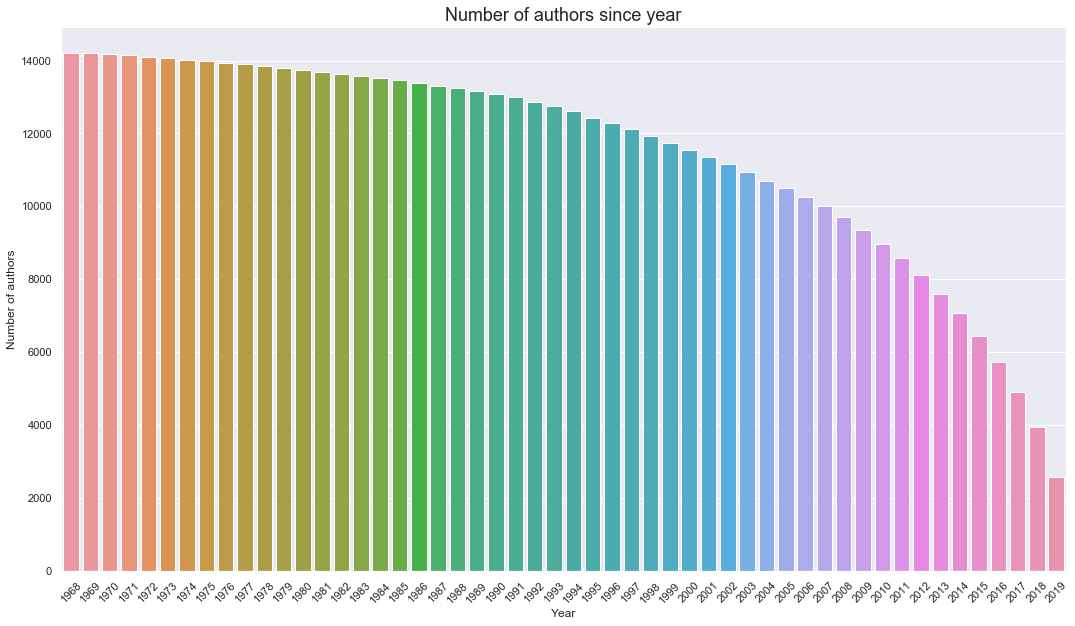

In [8]:
plt.figure(figsize=(18, 10))
plot = sns.barplot(x=list(range(1968,2020)),y=num_authors_list)
plt.xticks(rotation=45)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of authors", fontsize=12)
plt.title("Number of authors since year", fontsize=18);

In [235]:
def get_papers_of_authors(author_ids):
    return paper_collection.aggregate([
        {
            "$match": {
                "kit_authors.id": {"$in":author_ids}
            }
        },
        {
            "$project":{
                "id":1,
                "normalized_title": 1,
                "abstract":1,
                "kit_authors":{
                    "$filter": {
                       "input": "$kit_authors",
                       "as": "item",
                       "cond": { "$in": ["$$item.id", author_ids] }
                    }
                }
            }
        }
    ])

In [296]:
authors_since_2017 = get_authors_since(2017)
expert_papers = list(get_papers_of_authors(authors_since_2017))
print("Number of experts", len(authors_since_2017))
print("Number of papers published by current kit experts", len(expert_papers))

Number of experts 4904
Number of papers published by current kit experts 38954


In [297]:
paper_df = pd.DataFrame(expert_papers).drop("_id", axis=1)

In [298]:
print("Removed {} papers without abstracts".format(paper_df["abstract"].isnull().sum()))
paper_df = paper_df.dropna()

Removed 4775 papers without abstracts


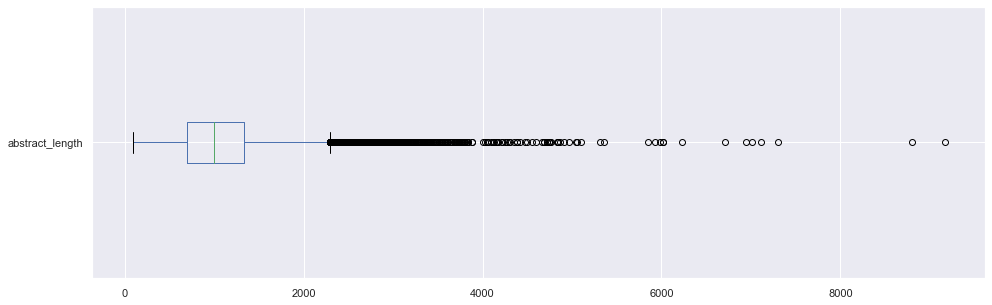

In [239]:
paper_df["abstract_length"] = paper_df["abstract"].apply(len)
# paper_df.plot.hist(by="abstract_length", bins=100, figsize=(16,10))
paper_df.boxplot(column="abstract_length", vert=False, figsize=(16,5));

In [240]:
print("Removed {} papers with more than 4000 characters".format((paper_df["abstract_length"] > 4000).sum()))
paper_df = paper_df[paper_df["abstract_length"] < 4000]

Removed 59 papers with more than 4000 characters


In [241]:
paper_df.sort_values(by="abstract_length")[["normalized_title", "abstract", "abstract_length"]].head()

,normalized_title,abstract,abstract_length
35885,erratum cloud service selection based on variability modeling,"In chapter 9, Figure 1 has been given incorrectly. The correct figure should be as follows:",91
6785,observation of the heavy baryons σb and σb,"7 paginas, 2 figuras, 2 tablas.-- PACS nrs.: 14.20.Mr, 13.30.Eg.-- CDF Collaboration: et al.",92
12841,anomale oberflachenzusammensetzung stochiometrischer mischoxid verbindungen,"Fil: Wachs, Israel E.. Lehigh University. Department of Chemical Engineering; Estados Unidos",92
25195,bestimmung des thermischen abbaus von feststoffen in einem isothermen gradientenfreien reaktor,"Cf Article en Anglais dans Chemical Engineering & Technology, 1998, Vol 21, No 4, pp. 332-337",93
557,search for bs0 μ μ and b0 μ μ decays with cdf ii,"7 paginas, 1 figura.-- PACS numbers: 13.20.He, 12.15.Mm, 12.60.Jv.-- CDF Collaboration: et al.",94


In [242]:
print("Removed {} papers with less than 400 characters".format((paper_df["abstract_length"] < 400).sum()))
paper_df = paper_df[paper_df["abstract_length"] > 400]

Removed 2395 papers with less than 400 characters


In [243]:
paper_df.sort_values(by="abstract_length")[["normalized_title", "abstract", "abstract_length"]].head()

,normalized_title,abstract,abstract_length
36448,damascus ein datenhaltungssystem fur den vlsi entwurf,"Aufgrund zunehmender Integrationsdichte elektronischer Bauteile fallt beim Entwurfsprozess eine grose Menge komplex strukurierter und vielfaltig zusammenhangender Informationen an, fur deren Verwaltung Datenbankkonzepte heute unumganglich sind. Gangige Datenbanksysteme erweisen sich jedoch in der Entwurfsumgebung als nicht sehr geeignet, da neuartige Anforderungen zu berucksichtigen sind [LOCK 85].",401
28911,high resolution thermal expansion of mgb2,The thermal expansion of polycrystalline MgB2 from 5–300 K is studied using high-resolution capacitance dilatometry. The thermal expansivity exhibits a small jump of −5.8×10−8 K−1 at Tc (in accord with expectations from the Ehrenfest relationship and published specific heat and pressure data) and a negative peak-like feature close to 5 K. No indications of any structural instabilities are observed.,401
5044,skyrmion spacetime defect,A finite-energy static classical solution is obtained for standard Einstein gravity coupled to an $SO(3)\ifmmode\times\else\texttimes\fi{}SO(3)$ chiral model of scalars (a Skyrme model). This nonsingular localized solution has nontrivial topology for both the spacetime manifold and the $SO(3)$ matter fields. The solution corresponds to a single spacetime defect embedded in flat Minkowski spacetime.,401
24227,the 2011 kit english asr system for the iwslt evaluation,"This paper describes our English Speech-to-Text (STT) system for the 2011 IWSLT ASR track. The system consists of 2 subsystems with different front-ends—one MVDR based, one MFCC based—which are combined using confusion network combination to provide a base for a second pass speaker adapted MVDR system. We demonstrate that this set-up produces competitive results on the IWSLT 2010 dev and test sets.",401
32830,laser doppler anemometry a non intrusive optical measuring technique for fluid velocity,"The present paper gives an introduction to laser Doppler anemometry. The fundamental principles of this measuring technique, as well as the basic features of its instrumental realizations, are explained. The application of laser Doppler anemometry to fluid investigations often requires an adaptation of the LDA-system to the measuring problem. Basic formulas for the lay-out and adaptation are given.",401


In [205]:
paper_df["abstract"] = paper_df["abstract"].apply(lambda text: re.sub(r"(\r|\n)+", " ", text))

In [206]:
wtl = WhatTheLang()
paper_df["lang_wtl"] = paper_df["abstract"].apply(wtl.predict_lang)

In [207]:
paper_df["lang_langid"] = paper_df["abstract"].apply(lambda a: langid.classify(a)[0])

In [208]:
paper_df[paper_df["lang_wtl"] != paper_df["lang_langid"]][["lang_wtl", "lang_langid", "abstract"]].head(10)

,lang_wtl,lang_langid,abstract
166,en,lb,"L. Accardo, M. Aguilar, D. Aisa, B. Alpat, A. Alvino, G. Ambrosi, K. Andeen, L. Arruda, N. Attig, P. Azzarello, A. Bachlechner, F. Barao, A. Barrau, L. Barrin, A. Bartoloni, L. Basara, M. Battarbee, R. Battiston, J. Bazo, U. Becker, M. Behlmann, B. Beischer, J. Berdugo, B. Bertucci, G. Bigongiari, V. Bindi, S. Bizzaglia, M. Bizzarri, G. Boella, W. de Boer, K. Bollweg, V. Bonnivard, B. Borgia, S. Borsini, M. J. Boschini, M. Bourquin, J. Burger, F. Cadoux, X. D. Cai, M. Capell, S. Caroff, G. Carosi, J. Casaus, V. Cascioli, G. Castellini, I. Cernuda, D. Cerreta, F. Cervelli, M. J. Chae, Y. H. Chang, A. I. Chen, H. Chen, G. M. Cheng, H. S. Chen, L. Cheng, A. Chikanian, H. Y. Chou, E. Choumilov, V. Choutko, C. H. Chung, F. Cindolo, C. Clark, R. Clavero, G. Coignet, C. Consolandi, A. Contin, C. Corti, B. Coste, Z. Cui, M. Dai, C. Delgado, S. Della Torre, M. B. Demirkoz, L. Derome, S. Di Falco, L. Di Masso, F. Dimiccoli, C. Diaz, P. von Doetinchem, W. J. Du, M. Duranti, D. D’Urso, A. Elin..."
187,en,lb,"M. Aguilar, D. Aisa, A. Alvino, G. Ambrosi, K. Andeen, L. Arruda, N. Attig, P. Azzarello, A. Bachlechner, F. Barao, A. Barrau, L. Barrin, A. Bartoloni, L. Basara, M. Battarbee, R. Battiston, J. Bazo, U. Becker, M. Behlmann, B. Beischer, J. Berdugo, B. Bertucci, G. Bigongiari, V. Bindi, S. Bizzaglia, M. Bizzarri, G. Boella, W. de Boer, K. Bollweg, V. Bonnivard, B. Borgia, S. Borsini, M. J. Boschini, M. Bourquin, J. Burger, F. Cadoux, X. D. Cai, M. Capell, S. Caroff, J. Casaus, V. Cascioli, G. Castellini, I. Cernuda, F. Cervelli, M. J. Chae, Y. H. Chang, A. I. Chen, H. Chen, G. M. Cheng, H. S. Chen, L. Cheng, A. Chikanian, H. Y. Chou, E. Choumilov, V. Choutko, C. H. Chung, C. Clark, R. Clavero, G. Coignet, C. Consolandi, A. Contin, C. Corti, B. Coste, Z. Cui, M. Dai, C. Delgado, S. Della Torre, M. B. Demirkoz, L. Derome, S. Di Falco, L. Di Masso, F. Dimiccoli, C. Diaz, P. von Doetinchem, W. J. Du, M. Duranti, D. D’Urso, A. Eline, F. J. Eppling, T. Eronen, Y. Y. Fan, L. Farnesini, J. ..."
296,ca,la,"The World Stress Map (WSM) project is a global compilation of information on the contemporary crustal stress field from a wide range of stress indicators. The WSM database release 2008 contains 21,750 stress data records that are quality‐ranked using an updated and refined quality‐ranking scheme. Almost 17,000 of these data records have A‐C quality and are considered to record the orientation of maximum horizontal compressional stress SH to within ±25°. As this is almost a triplication of data records compared with the first WSM database release in 1992, we reinvestigate the spatial wave‐length of the stress patterns with a statistical analysis on a global 0.5° grid. The resulting smoothed global stress map displays both; the mean SH orientation that follows from the maximum smoothing radius for which the standard deviation is b25° and a countour map that displays the wave‐length of the stress pattern. This smoothed global map confirms that long wave‐length stress patterns (N2000 k..."
5636,en,sw,"O. Lutz, S. Neubauer, M. Heck, T. Kuhr, A. Zupanc, I. Adachi, H. Aihara, D. M. Asner, T. Aushev, T. Aziz, A. M. Bakich, K. Belous, V. Bhardwaj, B. Bhuyan, A. Bondar, G. Bonvicini, A. Bozek, M. Bracko, 18 T. E. Browder, P. Chang, V. Chekelian, A. Chen, P. Chen, B. G. Cheon, R. Chistov, K. Cho, V. Chobanova, Y. Choi, D. Cinabro, J. Dalseno, 50 M. Danilov, 30 Z. Doležal, Z. Drasal, D. Dutta, S. Eidelman, D. Epifanov, H. Farhat, J. E. Fast, M. Feindt, V. Gaur, N. Gabyshev, S. Ganguly, R. Gillard, Y. M. Goh, B. Golob, 18 J. Haba, T. Hara, K. Hayasaka, H. Hayashii, Y. Hoshi, W.-S. Hou, Y. B. Hsiung, H. J. Hyun, T. Iijima, 32 A. Ishikawa, R. Itoh, Y. Iwasaki, T. Julius, J. H. Kang, P. Kapusta, E. Kato, T. Kawasaki, C. Kiesling, H. J. Kim, H. O. Kim, J. B. Kim, J. H. Kim, K. T. Kim, M. J. Kim, K. Kinoshita, J. Klucar, B. R. Ko, P. Kodys, S. Korpar, 18 R. T. Kouzes, P. Križan, 18 P. Krokovny, B. Kronenbitter, T. Kumi

In [209]:
english_paper = (paper_df["lang_wtl"] == "en") & (paper_df["lang_langid"] == "en")
paper_df = paper_df[english_paper]
print("Removed {} papers that are not written in english".format(sum(~english_paper)))

Removed 485 papers that are not written in english


In [210]:
paper_df["abstract"] = paper_df["normalized_title"] + " " + paper_df["abstract"]

In [221]:
KNOWN_CHAR_RE = re.compile(r"([^a-z0-9_ ])+") 
NUMBER_RE = re.compile(r"\b(\d+)\b")

In [ ]:
paper_df["abstract"] = paper_df["abstract"].apply(lambda text: text.lower())

In [292]:
paper_df["abstract"] = paper_df["abstract"].apply(lambda text: KNOWN_CHAR_RE.sub(" ", text))

In [223]:
paper_df["abstract"] = paper_df["abstract"].apply(lambda text: NUMBER_RE.sub(" ", text))

In [295]:
def sub_iso(text):
    return re.sub(
        r"\biso (\d+)(-(\d+))?\b",
        lambda m: f"iso_{m.group(1)}{'_'+m.group(3) if m.group(3) else ''}",
        text)
paper_df["abstract"] = paper_df["abstract"].apply(sub_iso)

In [ ]:
replacement_list = [
    ("n't ": " not "),
    ("'ve ": " have "),
    ("'ll ": " will "),
    ("'s ": " "),
    ("'d ": " ")
]

In [316]:
[x for x in paper_df["abstract"] if "GlobalPhone" in x]

['Abstract   With the distribution of speech technology products all over the world, the portability to new target languages becomes a practical concern. As a consequence our research focuses on the question of how to port large vocabulary continuous speech recognition (LVCSR) systems in a fast and efficient way. More specifically we want to estimate acoustic models for a new target language using speech data from varied source languages, but only limited data from the target language. For this purpose, we introduce different methods for multilingual acoustic model combination and a polyphone decision tree specialization procedure. Recognition results using language-dependent, independent and language-adaptive acoustic models are presented and discussed in the framework of our  GlobalPhone  project which investigates LVCSR systems in 15 languages.',
 "Building modern speech and language systems currently requires large data resources such as texts, voice recordings, pronunciation lexic